# Generate music with an RNN

## Setup

This project uses the [`pretty_midi`](https://github.com/craffel/pretty-midi) library to create and parse MIDI files, and [`pyfluidsynth`](https://github.com/nwhitehead/pyfluidsynth) for generating audio playback in Colab.

In [2]:
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin
  libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5
  libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme qttranslations5-l10n
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs qt5-image-formats-plugins qtwayland5 jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libevdev2 libfluidsynth3 libgudev-1.0-0
  libinput-bin libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a
  libqt5dbus5 libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libx

In [3]:
!pip install --upgrade pyfluidsynth

  Preparing metadata (setup.py) ... done
  Created wheel for pyfluidsynth: filename=pyFluidSynth-1.3.3-py3-none-any.whl size=19185 sha256=ec01c22c565eef4208835db84d5362df6620ef24820939c4a5c843ba913d50e7
  Stored in directory: /root/.cache/pip/wheels/e6/9c/2b/b4b194cbb100d6f20136a22b2f76cd329b1a21139ed26c9775
Successfully built pyfluidsynth


In [4]:
!pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 62.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.4 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592287 sha256=a696f44c91eaa407cb996ca854d5804c2efaa7683fa37ed47dbabcd1170613c5
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1


In [5]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

In [6]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

## Download the Maestro dataset

In [7]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

59243107/59243107 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


The dataset contains about 1,200 MIDI files.

In [8]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


## Process a MIDI file

In [9]:
sample_file = filenames[1]
print(sample_file)

data/maestro-v2.0.0/2006/MIDI-Unprocessed_10_R1_2006_01-04_ORIG_MID--AUDIO_10_R1_2006_02_Track02_wav.midi


In [10]:
pm = pretty_midi.PrettyMIDI(sample_file)

In [11]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [12]:
display_audio(pm)

In [13]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


## Extract notes

In [14]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=38, note_name=D2, duration=0.1758
1: pitch=62, note_name=D4, duration=0.2109
2: pitch=50, note_name=D3, duration=0.2044
3: pitch=37, note_name=C#2, duration=0.0430
4: pitch=61, note_name=C#4, duration=0.0482
5: pitch=35, note_name=B1, duration=0.0391
6: pitch=59, note_name=B3, duration=0.0404
7: pitch=33, note_name=A1, duration=0.0482
8: pitch=57, note_name=A3, duration=0.0365
9: pitch=61, note_name=C#4, duration=0.0339


In [15]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [16]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

pitch     start       end      step  duration
0     62  0.927083  1.138021  0.000000  0.210938
1     38  0.938802  1.114583  0.011719  0.175781
2     50  0.957031  1.161458  0.018229  0.204427
3     37  1.141927  1.184896  0.184896  0.042969
4     61  1.149740  1.197917  0.007812  0.048177

In [17]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['D4', 'D2', 'D3', 'C#2', 'C#4', 'B1', 'B3', 'A1', 'A3', 'C#2'],
      dtype='<U3')

In [18]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

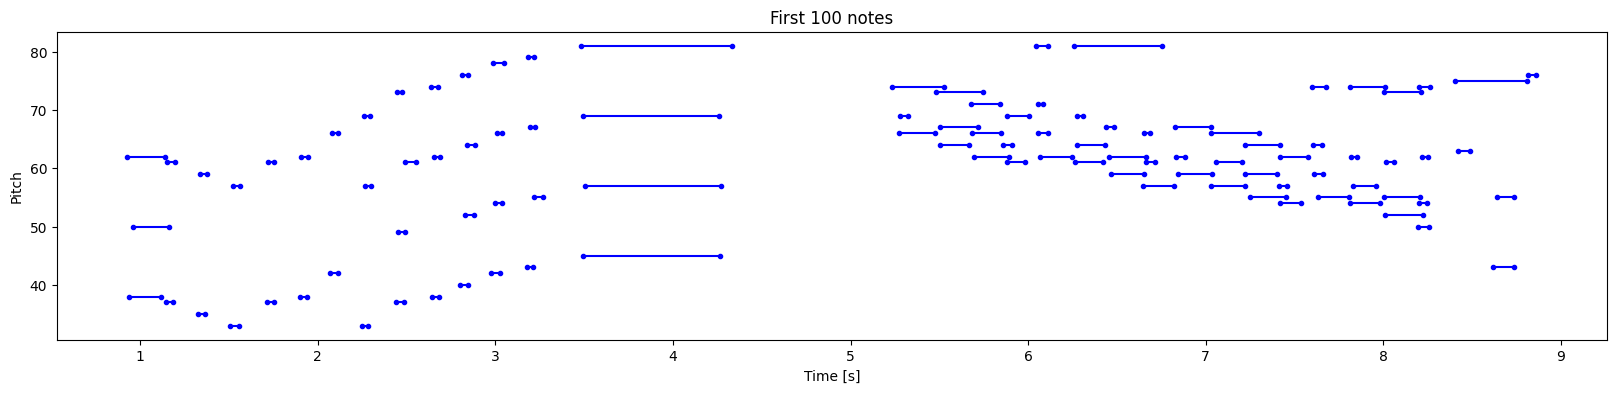

In [19]:
plot_piano_roll(raw_notes, count=100)

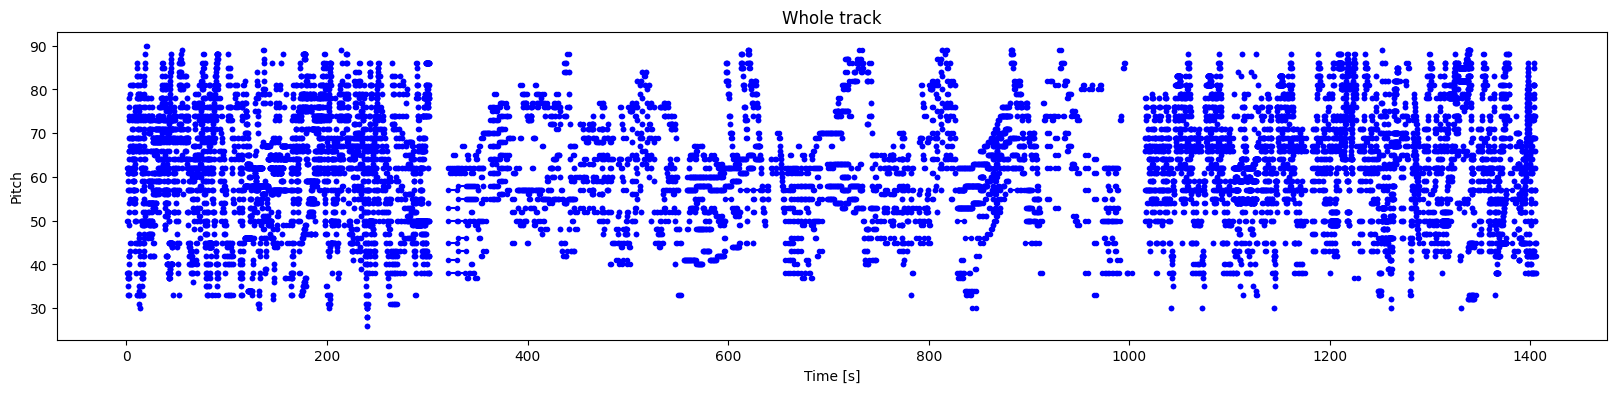

In [20]:
plot_piano_roll(raw_notes)

In [21]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

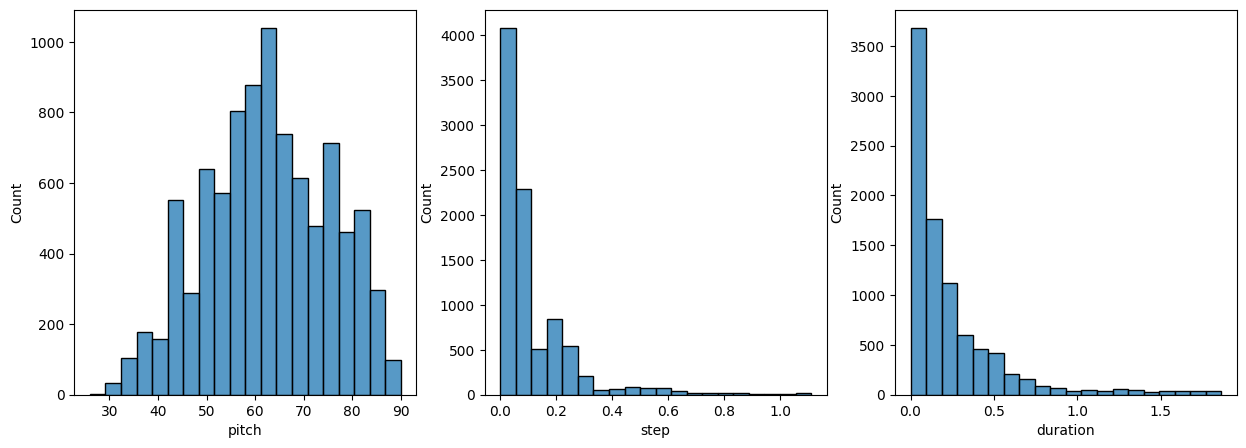

In [22]:
plot_distributions(raw_notes)

## Create MIDI File

In [23]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str,
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [24]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

Play the generated MIDI file and see if there is any difference.

In [25]:
display_audio(example_pm)

## Create the training dataset


In [26]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [27]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 27471


In [28]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [29]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [30]:
def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [31]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [32]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.5        0.         0.08854167]
 [0.46875    0.00911458 0.07942708]
 [0.5234375  0.0078125  0.07161458]
 [0.5078125  0.64453125 0.859375  ]
 [0.484375   0.00390625 0.11458333]
 [0.5234375  0.00520833 0.58333333]
 [0.4609375  1.38020833 0.10286458]
 [0.484375   0.00390625 0.15364583]
 [0.5234375  0.00651042 0.12109375]
 [0.5        0.68098958 0.64192708]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=67.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.674479166666667>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.09635416666666607>}


In [33]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [34]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

## Create and train the model

The model will have three outputs, one for each note variable. For `step` and `duration`, you will use a custom loss function based on mean squared error that encourages the model to output non-negative values.

In [35]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [36]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 25, 3)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 128)            │         67,584 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ duration (Dense)          │ (None, 1)              │            129 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pitch (Dense)             │ (None, 128)            │         16,512 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ step (Dense)              │ (None, 1)              │            129 │ lstm[0][0]             │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 84,354 (329.51 KB)

 Trainable params: 84,354 (329.51 KB)

 Non-trainable params: 0 (0.00 B)

Testing the `model.evaluate` function, you can see that the `pitch` loss is significantly greater than the `step` and `duration` losses.
Note that `loss` is the total loss computed by summing all the other losses and is currently dominated by the `pitch` loss.

In [37]:
losses = model.evaluate(train_ds, return_dict=True)
losses

428/428 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 5.7017


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


{'loss': 5.703303337097168}

In [38]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [39]:
model.evaluate(train_ds, return_dict=True)

428/428 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0956


{'loss': 1.1106892824172974}

In [40]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}.weights.h5',  # Ensure the file extension is correct
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [41]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.3835
Epoch 2/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.3436
Epoch 3/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.3386
Epoch 4/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.3342
Epoch 5/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.3305
Epoch 6/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.3291
Epoch 7/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.3264
Epoch 8/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.3233
Epoch 9/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.3207
Epoch 10/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.3189
Epoch 11/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.3178
Epoch 12/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3156
Epoch 13/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3130
Epoch 14/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3137
Epoch 15/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - lo

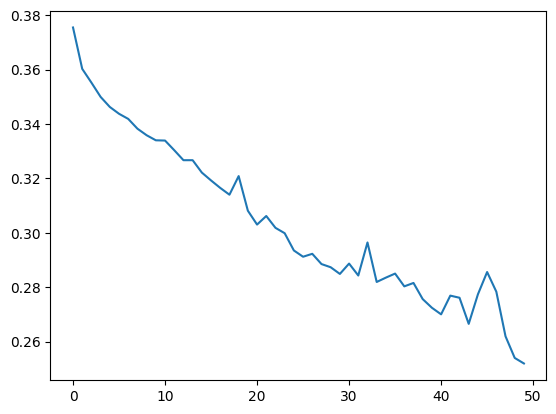

In [42]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

## Generate notes

To use the model to generate notes, you will first need to provide a starting sequence of notes. The function below generates one note from a sequence of notes.

For note pitch, it draws a sample from the softmax distribution of notes produced by the model, and does not simply pick the note with the highest probability.
Always picking the note with the highest probability would lead to repetitive sequences of notes being generated.

The `temperature` parameter can be used to control the randomness of notes generated.

In [43]:
def predict_next_note(
    notes: np.ndarray,
    model: tf.keras.Model,
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [44]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

In [45]:
generated_notes.head(10)

pitch      step  duration     start       end
0     47  0.057257  0.077933  0.057257  0.135190
1     80  0.337002  0.000000  0.394259  0.394259
2     80  0.437229  0.000000  0.831488  0.831488
3     86  0.462959  0.000000  1.294447  1.294447
4     80  0.473917  0.000000  1.768365  1.768365
5    101  0.470041  0.000000  2.238406  2.238406
6     86  0.476915  0.000000  2.715322  2.715322
7     95  0.472030  0.000000  3.187352  3.187352
8    101  0.477928  0.000000  3.665280  3.665280
9     83  0.477998  0.000000  4.143278  4.143278

In [46]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

Visualize the generated notes.

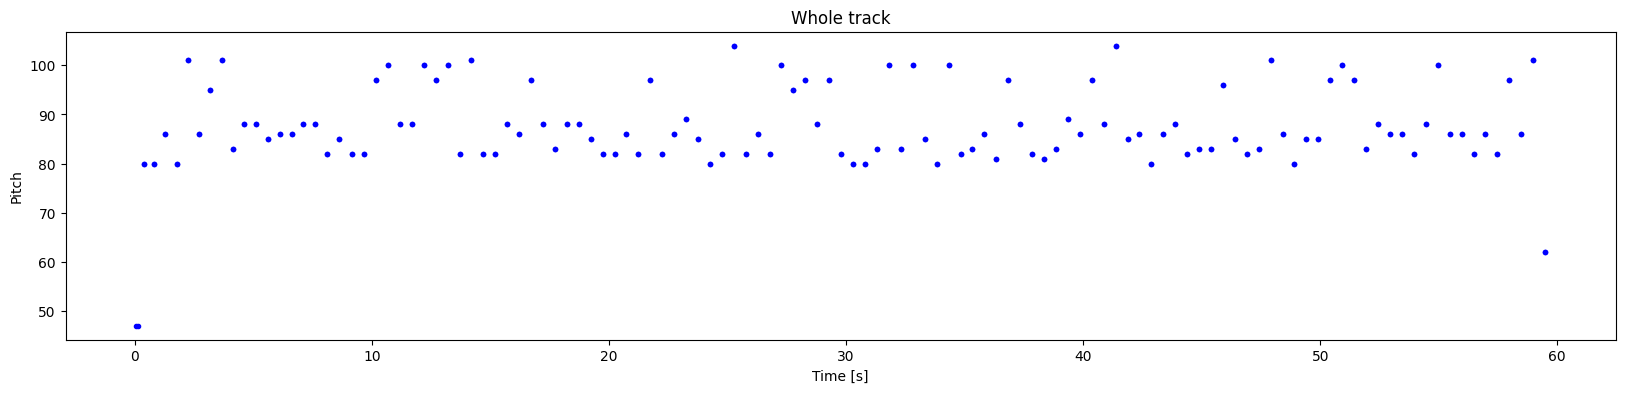

In [47]:
plot_piano_roll(generated_notes)

Check the distributions of `pitch`, `step` and `duration`.

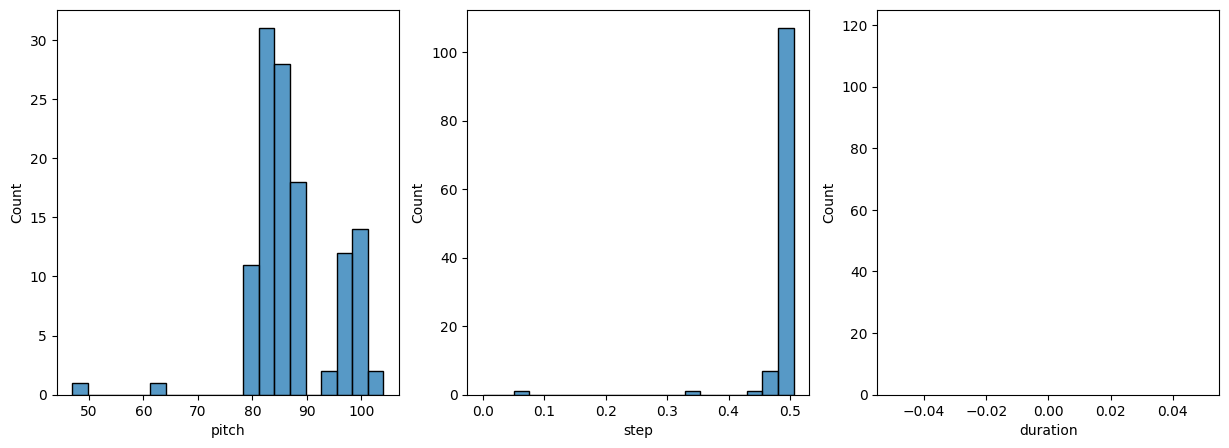

In [48]:
plot_distributions(generated_notes)

In [49]:
!pip install ipywidgets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 38.4 MB/s eta 0:00:00


In [50]:
import ipywidgets as widgets
from IPython.display import display, Audio
import numpy as np
import pandas as pd
import pretty_midi

# Define the input widgets for user interaction
temperature_slider = widgets.FloatSlider(
    value=1.0,
    min=0.5,
    max=2.0,
    step=0.1,
    description='Temperature',
)

num_predictions_slider = widgets.IntSlider(
    value=120,
    min=50,
    max=500,
    step=10,
    description='Number of Notes',
)

instrument_dropdown = widgets.Dropdown(
    options=['Acoustic Grand Piano', 'Violin', 'Flute', 'Electric Guitar (jazz)'],
    value='Acoustic Grand Piano',
    description='Instrument',
)

generate_button = widgets.Button(description="Generate Music")

# Function to display audio from a MIDI file
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
    # Generate waveform using fluidsynth
    waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
    waveform_short = waveform[:seconds * _SAMPLING_RATE]
    return Audio(waveform_short, rate=_SAMPLING_RATE)

# Function triggered on button click to generate music
def on_generate_music_clicked(b):
    # Get user input values
    temperature = temperature_slider.value
    num_predictions = num_predictions_slider.value
    instrument_name = instrument_dropdown.value

    print(f"Generating {num_predictions} notes with temperature {temperature} using {instrument_name}...")

    # Use the first sequence of notes as input
    sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)
    input_notes = (sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

    generated_notes = []
    prev_start = 0

    # Generate new notes based on user-defined parameters
    for _ in range(num_predictions):
        pitch, step, duration = predict_next_note(input_notes, model, temperature)
        start = prev_start + step
        end = start + duration
        input_note = (pitch, step, duration)
        generated_notes.append((*input_note, start, end))
        input_notes = np.delete(input_notes, 0, axis=0)
        input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
        prev_start = start

    # Convert generated notes to MIDI and play it
    generated_notes_df = pd.DataFrame(generated_notes, columns=(*key_order, 'start', 'end'))
    out_pm = notes_to_midi(generated_notes_df, out_file='output.mid', instrument_name=instrument_name)

    # Display the generated audio and plots
    audio = display_audio(out_pm)
    display(audio)
    plot_piano_roll(generated_notes_df)
    plot_distributions(generated_notes_df)

# Bind the generate button to the function
generate_button.on_click(on_generate_music_clicked)

# Display the widgets
display(temperature_slider, num_predictions_slider, instrument_dropdown, generate_button)


FloatSlider(value=1.0, description='Temperature', max=2.0, min=0.5)

IntSlider(value=120, description='Number of Notes', max=500, min=50, step=10)

Dropdown(description='Instrument', options=('Acoustic Grand Piano', 'Violin', 'Flute', 'Electric Guitar (jazz)…

Button(description='Generate Music', style=ButtonStyle())

## Evaluation

In [55]:
# Splitting the dataset into training and validation sets
train_size = int(0.8 * len(all_notes))
train_notes = all_notes[:train_size]
val_notes = all_notes[train_size:]

# Create TensorFlow datasets for training and validation
train_notes_ds = tf.data.Dataset.from_tensor_slices(np.stack([train_notes[key] for key in key_order], axis=1))
val_notes_ds = tf.data.Dataset.from_tensor_slices(np.stack([val_notes[key] for key in key_order], axis=1))

# Prepare sequences for both training and validation sets
train_seq_ds = create_sequences(train_notes_ds, seq_length, vocab_size)
val_seq_ds = create_sequences(val_notes_ds, seq_length, vocab_size)

# Batch the validation set
val_ds = val_seq_ds.batch(batch_size, drop_remainder=True).cache().prefetch(tf.data.experimental.AUTOTUNE)


In [56]:
# Training the model with validation data
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=callbacks,
)


Epoch 1/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - duration_mean_squared_error: 0.0435 - loss: 0.2404 - pitch_sparse_categorical_accuracy: 0.0935 - step_mean_squared_error: 0.0183 - val_duration_mean_squared_error: 0.0188 - val_loss: 0.2039 - val_pitch_sparse_categorical_accuracy: 0.0985 - val_step_mean_squared_error: 0.0093
Epoch 2/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - duration_mean_squared_error: 0.0388 - loss: 0.2331 - pitch_sparse_categorical_accuracy: 0.0974 - step_mean_squared_error: 0.0165 - val_duration_mean_squared_error: 0.0181 - val_loss: 0.2032 - val_pitch_sparse_categorical_accuracy: 0.1001 - val_step_mean_squared_error: 0.0097
Epoch 3/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - duration_mean_squared_error: 0.0374 - loss: 0.2304 - pitch_sparse_categorical_accuracy: 0.0996 - step_mean_squared_error: 0.0164 - val_duration_mean_squared_error: 0.0180 - val_loss: 0.2024 - val_pitch_sparse_categorical_accuracy: 0.0987 - val_step_mean_squared_error: 0.0091
Epoch 4/50

In [57]:
# Evaluate on the validation set
val_losses = model.evaluate(val_ds, return_dict=True)
print("Validation Losses:", val_losses)


85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - duration_mean_squared_error: 0.0254 - loss: 0.2094 - pitch_sparse_categorical_accuracy: 0.1123 - step_mean_squared_error: 0.0102
Validation Losses: {'duration_mean_squared_error': 0.01797800324857235, 'loss': 0.20351870357990265, 'pitch_sparse_categorical_accuracy': 0.10183823853731155, 'step_mean_squared_error': 0.009174637496471405}


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  


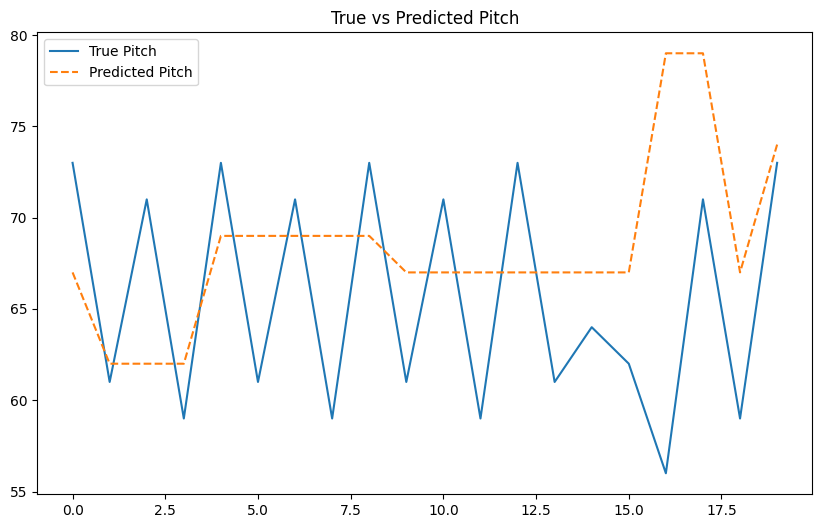

In [59]:
# Get one batch of validation data
for val_seq, val_target in val_ds.take(1):  # val_ds is the validation dataset
    # Predict on the validation sequence
    predictions = model.predict(val_seq)

    # Extract true and predicted pitch values
    true_pitch = val_target['pitch']  # True pitch values
    predicted_pitch = tf.argmax(predictions['pitch'], axis=-1)  # Predicted pitch values

# Convert tensors to numpy arrays for plotting
true_pitch = true_pitch.numpy()
predicted_pitch = predicted_pitch.numpy()

# Plot true vs predicted pitch for a batch of validation data
plt.figure(figsize=(10, 6))
plt.plot(true_pitch[:20], label='True Pitch')
plt.plot(predicted_pitch[:20], label='Predicted Pitch', linestyle='--')
plt.title('True vs Predicted Pitch')
plt.legend()
plt.show()
